In [1]:
import random
import numpy as np
import torch
import torch.nn

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

n_features = 3

In [2]:
def make_data(n_features=n_features, N=1000, eps=0.1):
    coefs = torch.randn(n_features)
    intercept = torch.randn(1)
    noise = torch.randn(N) * eps
    x = torch.rand(N, n_features)
    y = ((coefs * x).sum(dim=1, keepdim=True) +
         intercept.view(1, -1) +
         noise.view(N, -1))
    return x, y, coefs, intercept

In [3]:
x, y, coefs, intercept = make_data()

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

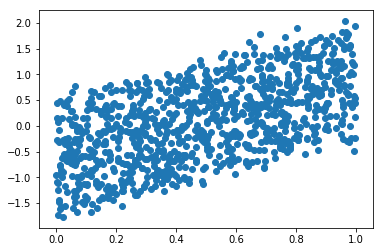

In [5]:
plt.scatter(x[:,0], y);

# Gradient descent over full set

In [6]:
model = torch.nn.Linear(n_features, 1, bias=True)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.train()

loss_history = []

for epoch in range(5000):
    optimizer.zero_grad()
    ypred = model(x)
    loss = loss_fn(ypred, y)
    loss_history.append(loss.item())
    if epoch % 500 == 0:
        print(epoch, loss.item())
    loss.backward()
    optimizer.step()

0 0.3955398201942444
500 0.08792349696159363
1000 0.026550613343715668
1500 0.013848661445081234
2000 0.011068891733884811
2500 0.010405500419437885
3000 0.010227799415588379
3500 0.010173873044550419
4000 0.010155650787055492
4500 0.01014900952577591


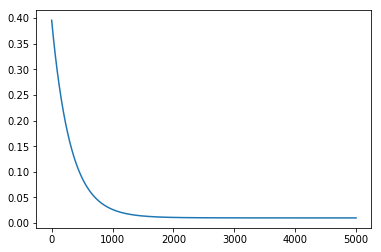

In [7]:
plt.plot(loss_history);

In [8]:
list(model.parameters())

[Parameter containing:
 tensor([[ 1.5514, -0.2931, -2.1742]], requires_grad=True),
 Parameter containing:
 tensor([0.5609], requires_grad=True)]

In [9]:
print(coefs, intercept)

tensor([ 1.5410, -0.2934, -2.1788]) tensor([0.5684])


# Stochastic gradient descent (batch_size=1)

In [10]:
%%time 

model = torch.nn.Linear(n_features, 1, bias=True)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.train()

loss_history = []

for epoch in range(5):
    for xi, yi in zip(x, y):
        optimizer.zero_grad()
        ypred = model(xi)
        loss = loss_fn(ypred, yi)
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
    print(epoch, loss.item())

0 0.004100662190467119
1 0.020480699837207794
2 0.02539123222231865
3 0.026463566347956657
4 0.026685822755098343
CPU times: user 869 ms, sys: 90.3 ms, total: 960 ms
Wall time: 952 ms


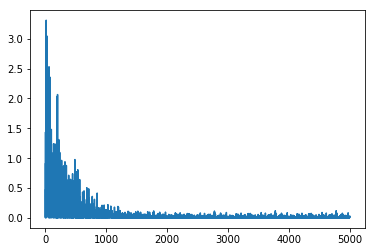

In [11]:
plt.plot(loss_history);

In [12]:
list(model.parameters())

[Parameter containing:
 tensor([[ 1.5443, -0.2983, -2.1685]], requires_grad=True),
 Parameter containing:
 tensor([0.5514], requires_grad=True)]

In [13]:
print(coefs, intercept)

tensor([ 1.5410, -0.2934, -2.1788]) tensor([0.5684])


# Minibatches with DataLoader

In [14]:
import torch.utils.data

class LRDataset(torch.utils.data.Dataset):
    def __init__(self, *args, **kwargs):
        self.x, self.y, self.coefs, self.intercept = make_data(*args, **kwargs)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [15]:
lrdataloader = torch.utils.data.DataLoader(LRDataset(), batch_size=16, shuffle=True)

In [16]:
for x, y in lrdataloader:
    print(x, y)
    break

tensor([[0.5157, 0.9890, 0.0677],
        [0.4539, 0.0984, 0.2230],
        [0.1719, 0.5704, 0.9847],
        [0.0532, 0.6463, 0.1495],
        [0.8594, 0.8737, 0.0106],
        [0.0691, 0.7350, 0.4705],
        [0.0810, 0.8404, 0.2095],
        [0.5167, 0.6712, 0.1436],
        [0.9547, 0.8188, 0.9609],
        [0.5205, 0.5187, 0.9259],
        [0.2039, 0.7748, 0.3204],
        [0.3255, 0.2580, 0.3764],
        [0.2044, 0.6802, 0.7017],
        [0.5052, 0.7841, 0.1607],
        [0.4970, 0.7005, 0.3318],
        [0.8340, 0.8730, 0.5012]]) tensor([[-0.6110],
        [-0.2061],
        [-1.6771],
        [-0.9496],
        [-0.4716],
        [-1.4095],
        [-0.8342],
        [-0.5113],
        [-1.0839],
        [-0.9681],
        [-0.9578],
        [-0.5453],
        [-1.3775],
        [-0.6731],
        [-0.8090],
        [-0.8536]])


In [17]:
%%time 

model = torch.nn.Linear(n_features, 1, bias=True)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model.train()

loss_history = []

for epoch in range(25):
    for xs, ys in lrdataloader:
        optimizer.zero_grad()
        ypred = model(xs)
        loss = loss_fn(ypred, ys)
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
    print(epoch, loss.item())

0 0.05369071662425995
1 0.016543976962566376
2 0.014540726318955421
3 0.007798833306878805
4 0.011074160225689411
5 0.012370729818940163
6 0.0046897693537175655
7 0.0035382371861487627
8 0.012607494369149208
9 0.012864058837294579
10 0.003718314226716757
11 0.005991102196276188
12 0.008489939384162426
13 0.008186539635062218
14 0.006630820222198963
15 0.008285642601549625
16 0.00626192195340991
17 0.017683861777186394
18 0.012726160697638988
19 0.0030189035460352898
20 0.012380375526845455
21 0.010217336006462574
22 0.010431278496980667
23 0.010539200156927109
24 0.02071944624185562
CPU times: user 612 ms, sys: 52.6 ms, total: 665 ms
Wall time: 694 ms


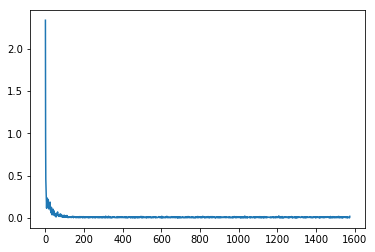

In [18]:
plt.plot(loss_history);

In [19]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.6833, -0.6567, -1.1080]], requires_grad=True),
 Parameter containing:
 tensor([-0.2782], requires_grad=True)]

In [20]:
print(lrdataloader.dataset.coefs, lrdataloader.dataset.intercept)

tensor([ 0.6554, -0.6485, -1.1388]) tensor([-0.2715])
